In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import sys
sys.path.append('../')

from util import *


In [2]:
# code adapted from ChatGPT

# Define your neural network model
class SL2Z_NN(nn.Module):
    def __init__(self):
        super(SL2Z_NN, self).__init__()

        self.step1 = nn.Linear(4, 128, bias=True)
        self.step2 = nn.ReLU()
        self.step3 = nn.Linear(128, 64, bias=True)
        self.step4 = nn.ReLU()
        self.step5 = nn.Linear(64, 16, bias=True)
        self.step6 = nn.ReLU()
        self.step7 = nn.Linear(16, 4, bias=True)

        # multi-class classification adapted from ChatGPT
        self.step8 = nn.Softmax(dim=1)

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.step5(x)
        x = self.step6(x)
        x = self.step7(x)
        x = self.step8(x)
        
        return x

def train_model(model, inputs, desired_outputs, num_epochs=100, learning_rate=0.01, viz_accuracy=False):
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Mean Squared Error loss
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []

    inputs = inputs.float()
    desired_outputs = desired_outputs.long()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass

            batch_desired_outputs = batch_desired_outputs.long()

            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item
        
        # Print the average loss for this epoch
        scheduler.step()
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

In [10]:
df = pd.read_csv(
    "../Data_Generation/Data_files/labeled_points/sl2_Z_3s_bfs_medium.csv")
test_df = pd.read_csv(
    "../Data_Generation/Data_files/labeled_points/sl2_Z_3s_bfs_xtra_small.csv")

train = df.drop("dist_to_id", axis=1)
just_input = train.drop('best_move', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = torch.tensor(just_input.values.tolist())
desired_output = torch.tensor(
    train['best_move'].tolist(), dtype=torch.float32).long()

nn_full: SL2Z_NN = SL2Z_NN()

total loss: 28.56427526473999
Epoch [1/500], Loss: 1.2984
total loss: 24.98064088821411
Epoch [2/500], Loss: 1.1355
total loss: 23.66472816467285
Epoch [3/500], Loss: 1.0757
total loss: 23.103639721870422
Epoch [4/500], Loss: 1.0502
total loss: 22.742682576179504
Epoch [5/500], Loss: 1.0338
total loss: 22.46726107597351
Epoch [6/500], Loss: 1.0212
total loss: 22.27172476053238
Epoch [7/500], Loss: 1.0124
total loss: 22.116879642009735
Epoch [8/500], Loss: 1.0053
total loss: 22.001472175121307
Epoch [9/500], Loss: 1.0001
total loss: 21.90415495634079
Epoch [10/500], Loss: 0.9956
total loss: 21.832955956459045
Epoch [11/500], Loss: 0.9924
total loss: 21.773249626159668
Epoch [12/500], Loss: 0.9897
total loss: 21.724237978458405
Epoch [13/500], Loss: 0.9875
total loss: 21.680665969848633
Epoch [14/500], Loss: 0.9855
total loss: 21.648603975772858
Epoch [15/500], Loss: 0.9840
total loss: 21.625654757022858
Epoch [16/500], Loss: 0.9830
total loss: 21.601115107536316
Epoch [17/500], Loss: 0.

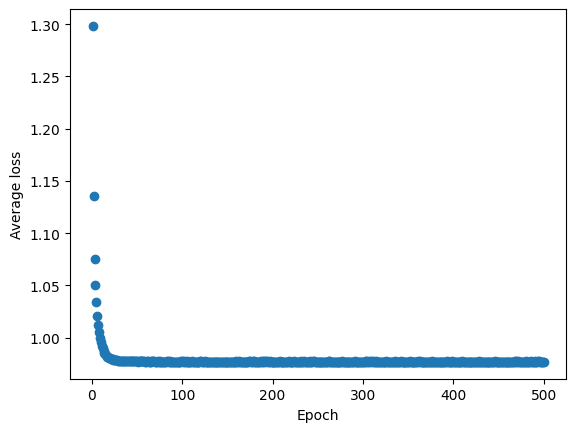

In [11]:
train_model(nn_full, input_data, desired_output, 500, learning_rate=0.0005, viz_accuracy=False)

In [12]:
if True:
    torch.save(nn_full.state_dict(), 'weights/sl2z_bfs_weights.pth')

In [35]:
if True:
    nn_full.load_state_dict(torch.load('weights/sl2z_bfs_weights.pth'))

In [36]:
def test_model(trained_model, new_data, expected_result):
    test_input = new_data.float()

    test_output = trained_model(test_input)

    predicted_classes = torch.argmax(test_output, dim=1)

    test_output_compare = expected_result.int()

    return float(sum(test_output_compare == predicted_classes)/len(test_input))

In [37]:
just_input_test = test_df.drop('dist_to_id', axis=1)
just_input_test = just_input_test.drop('best_move', axis=1)

input_data_test = torch.tensor(just_input_test.values.tolist(), dtype=torch.float32)
desired_output = torch.tensor(test_df['best_move'].tolist(), dtype=torch.long)

In [38]:
# how often model's first move matches Q learning's on train set
test_model(nn_full, input_data, torch.tensor(
    train['best_move'].tolist(), dtype=torch.int))

0.7651529312133789

In [42]:
def num_steps_to_origin_w_nn(test_mat):
    original = test_mat
    for i in range(100):
        if is_done(test_mat):
            print("we were successful with", matrix_to_tuple(original), "with", i, "steps!")
            return i
        demo_test_type = torch.tensor([matrix_to_tuple(test_mat)], dtype=torch.float32)
        action = int(torch.argmax(nn_full(demo_test_type)))

        test_mat = test_mat @ k_sl2z_2s_gen[action]
    return -1

In [43]:
test_df['num_steps_to_origin'] = test_df.apply(lambda row: num_steps_to_origin_w_nn((df_row_to_mat(row))), axis=1)
print("Num successful: ", int(sum(test_df['num_steps_to_origin'] != -1)))
print("Number total: ", test_df.size)

we were successful with (1.0, 0.0, 0.0, 1.0) with 3 steps!
we were successful with (1.0, 0.0, 0.0, 1.0) with 6 steps!
we were successful with (1.0, 0.0, 0.0, 1.0) with 3 steps!
we were successful with (1.0, 0.0, 0.0, 1.0) with 6 steps!
we were successful with (1, 0, 0, 1) with 0 steps!
we were successful with (1.0, 0.0, 0.0, 1.0) with 3 steps!
we were successful with (1.0, 0.0, 0.0, 1.0) with 6 steps!
we were successful with (1.0, 0.0, 0.0, 1.0) with 3 steps!
we were successful with (1, 0, 0, 1) with 0 steps!
we were successful with (1.0, 0.0, 0.0, 1.0) with 3 steps!
we were successful with (1, 0, 0, 1) with 0 steps!
we were successful with (1.0, 0.0, 0.0, 1.0) with 3 steps!
we were successful with (1, 0, 0, 1) with 0 steps!
we were successful with (1.0, 0.0, 0.0, 1.0) with 3 steps!
we were successful with (1.0, 0.0, 0.0, 1.0) with 3 steps!
we were successful with (1, 0, 0, 1) with 0 steps!
we were successful with (1.0, 0.0, 0.0, 1.0) with 3 steps!
we were successful with (1, 0, 0, 1) 